**<h1><center>CS 464</center></h1>**
**<h1><center>Introduction to Machine Learning</center></h1>**
**<h1><center>Spring 2022</center></h1>**
**<h1><center>Homework 3</center></h1>**
<h4><center>Due: DEC 23, 2022 23:59 (GMT+3)</center></h4>

In this third homework assignment, you are asked to develop a system that can be used to supply additional information to weather forecasts. For this task, you are provided a dataset that consists of weather images that belong to four different weather conditions: [cloudy, rain, shiny, sunrise]. Your model will classify images considering these class labels. 

For this assignment, **using PyTorch is mandatory.**

**Tip:** You may experience latencies in file I/O if you are using Google Colab. In this regard, we recommend you upload your data to Google Drive as a zip file and unzip the folder contents in your drive. If you would like to upload the data files separately, it may take significant time.

You will submit a single ipynb file as the homework submission. If you want to provide further explanation about your work, you can add Markdown cells to do so. [Here](https://www.markdownguide.org/), you can find a guide for Markdown syntax. Upload your homework with the following filename convention: \<BilkentID\>\_\<Name\>\_\<Surname\>.ipynb

**Contact:**
- [Yusuf Dalva](mailto:yusuf.dalva@bilkent.edu.tr)
- [Ahmet Burak Yıldırım](mailto:a.yildirim@bilkent.edu.tr)

**Dataset**<br>
You can find the dataset [here](https://www.kaggle.com/datasets/pratik2901/multiclass-weather-dataset). 


# **Q1** [12 points]
This part consists of 4 questions which you are expected to answer. Please fill in the following cell in Markdown format. Each question is worth 2 points.

a) Do we need to output the actual probability values when performing classification with the softmax layer? If not, how do these numbers represent the likelihood of classes? Also, does the output values should be in a specific range for us to make a classification? <br>

b) From the perspective of model complexity, how you can identify when a model underfits or overfits? Which plots are informative for detecting this behavior? <br>

c) In neural networks, how does the ReLU function help us to generalize to conplex feature spaces? Why we are not using linear layers only? <br>

d) Assume that you are going to pass the feature matrix with dimensions 64x64x5 (Height x Width x Channel size) through a convolutional layer. If our convolutional layer has a kernel size of 3x3 and the number of filters is 6, how many learnable parameters are present? <br>

a) No, we do not need to output the actual probability values. We generally do np.argmax operation to get the highest probable index. These numbers are coming from the formula: 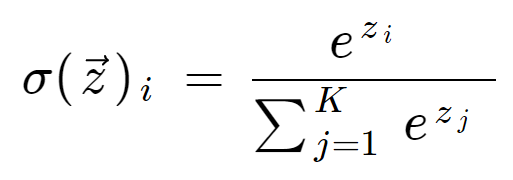 (https://deepai.org/machine-learning-glossary-and-terms/softmax-layer) <br />
The output values are in the range of [0,1]. <br /> <br />

b) Comparison of validation loss and training loss graphs helps me to identify underfitting or overfitting. If validation loss is relatively higher than training loss, there is an overfitting case. In the opposite way, if validation loss is relatively lower than training loss, this means that the model did not learn much from the training data and there is an underfitting case. <br /> <br />

c) The reason for us not only use linear layers is that for non-linear problems, neural network has to apply non-linear transformation. Therefore, we prefer non linear activation functions. ReLU can provide sparse representation by outputing zero value for negative inputs, which can accelerate the learning process and simplify the model. Moreover, group of ReLU units can form complex polyhedra along the class boundaries (https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/,https://towardsdatascience.com/if-rectified-linear-units-are-linear-how-do-they-add-nonlinearity-40247d3e4792).<br /> <br />

d) 3 * 3 * 5 * 6 + 6 = 276

# **Q2** [88 points]

## Necessary Imports
In the cell below, we import some utilities that you can make use of in this assignment. Note that you need to use PyTorch in this assignment. To report certain metrics (like precision, recall, accuracy) you may use utilities from *scikit-learn* library. You can edit these imports considering your implementation as long as you use PyTorch.

## Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os 
import time
import random

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score

import seaborn as sns

Mounted at /content/drive


You can test whether hardware acceleration with GPU is enabled in the cell below. In addition, if you have GPU access, you can check the amount of available GPU memory.

In [ ]:
# setting device as GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# CUDA device information
if device.type == 'cuda':
    print('GPU Name:', torch.cuda.get_device_name(0))
    print('Memory Stats:')
    print('  - Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('  - Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
    print('  - Total:    ', round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), 'GB')

Using device: cuda
GPU Name: Tesla T4
Memory Stats:
  - Allocated: 0.0 GB
  - Cached:    0.0 GB
  - Total:     14.8 GB


**DO NOT CHANGE**<br>
To evaluate your implementation fairly, we set seed values for random sampling methods in PyTorch, Numpy, and Python random library. These seeds are set to evaluate your models successfully, so do not change these values.

In [ ]:
# for reproducable results
torch.manual_seed(464)
torch.cuda.manual_seed(464)
np.random.seed(464)
random.seed(464)
if device.type == 'cuda':
    torch.backends.cudnn.deterministic=True

## Load Data [6 points]
In this assignment, you will use a custom dataset, which you need a wrapper class to access its data. For this purpose, implement a custom dataset class to organize data with the specifications you need. This class will load batches of data using a PyTorch DataLoader later. The class signature of CustomDataset class is provided to you in the cell below, where you can implement your custom dataset.

**IMPORTANT:** As you may have difficulties while fitting all images to your RAM, you need to read the images while getting that item (each item is an image here). We encourage you to read the data files in the "__getitem__" function to avoid encountering any issues related to fitting the data to memory. This way, you do not need to hold the dataset in a single variable, which would be memory intensive.

In [ ]:
class WeatherDataset(Dataset):
    def __init__(self, x, y, **kwargs):
        self.x = torch.tensor(x,dtype=torch.float,device=device)
        self.y = torch.tensor(y,dtype=torch.float,device=device)

    '''This function should return sample count in the dataset'''
    def __len__(self):
        return self.y.size(dim=0)

    '''This function should return a single sample and its ground truth value from the dataset corresponding to index parameter '''
    def __getitem__(self, index):
        return (self.x[index],self.y[index])

You can implement an additional function to read and construct custom dataset objects for training, validation, and test sets. While constructing the dataset, consider the following issues:
- Dataset contains images that end with prefixes *.jpg* and *.jpeg*.
- If you use PIL to read images, you should convert them to "RGB" format to operate on three color channels.
- Resize the dataset images to 224x224. You are going to design models that take images with tensor shape 224x224x3.
- If you wish, you can change the ordering of the color channels with np.moveaxis function

Lastly, the train-validation-test split for the dataset provided to you is 70-10-20 in terms of percentages. While constructing the dataset, remember that shuffling is a necessary step (to get randomly distributed classes across batches).

You can design your dataset getter method compatible with the line provided below, where train_dataset, val_dataset, and test_dataset are all instances of CustomDataset.

In [ ]:
root_dir = "/content/drive/MyDrive/Homework/WeatherDataset"
#y should be one encoded
#normalize image data and resize to 224x224
def load_dataset(root_dir):
  x = []
  y = []
  current_label = 0
  label_name_dict = {} # For instance: {'Shine': 0, 'Cloudy': 1, 'Sunrise': 2, 'Rain': 3}
  #load data and labels to x and y
  for root,sub_dirs,files in os.walk(root_dir):
    for sub_dir in sub_dirs:
      sub_dir_path = f"{root}/{sub_dir}"
      label_name_dict[sub_dir] = current_label
      for _,_,image_paths in os.walk(sub_dir_path):
        for image_path in image_paths:
          image = Image.open(f"{sub_dir_path}/{image_path}").convert("RGB").resize((224,224), Image.BILINEAR)       
          x.append(np.array(image,dtype=np.float64))
          one_hot_encoded_vector = np.zeros(len(sub_dirs))
          one_hot_encoded_vector[current_label] = 1
          y.append(one_hot_encoded_vector)

      current_label = current_label + 1

  #convert this lists to np.array
  x = np.array(x,dtype=np.float64).transpose((0,3,1,2)) #adjust sizes to match with pytorch input
  y = np.array(y,dtype=np.float64)

  #shuffle the data
  N = x.shape[0]
  sample_order = np.random.permutation(N)
  x = x[sample_order,:]
  y = y[sample_order]

  #70% training
  traininig_samples = int(N * 7 / 10)
  x_train = x[0:traininig_samples]
  y_train = y[0:traininig_samples]
  #10% validation
  validation_samples = int(N / 10)
  x_valid = x[traininig_samples:(traininig_samples+validation_samples)]
  y_valid = y[traininig_samples:(traininig_samples+validation_samples)]
  #20% test
  x_test = x[(traininig_samples+validation_samples):]
  y_test = y[(traininig_samples+validation_samples):]

  #Normalize x values --> x_train should be between 0 and 1 and other x values should be normalized according to x_train scales.
  max_x_train = x_train.max()
  min_x_train = x_train.min()

  x_train = (x_train - min_x_train) / (max_x_train - min_x_train)
  x_valid = (x_valid - min_x_train) / (max_x_train - min_x_train)
  x_test = (x_test - min_x_train) / (max_x_train - min_x_train)

  #Create WeatherDataset objects for train, valid and test arrays
  train_dataset = WeatherDataset(x_train,y_train)
  val_dataset = WeatherDataset(x_valid, y_valid)
  test_dataset = WeatherDataset(x_test,y_test)
  
  return train_dataset,val_dataset,test_dataset,label_name_dict

train_dataset, val_dataset, test_dataset, label_name_dict = load_dataset(root_dir)

## Models [16 points]
In this assignment, you will implement one CNN (Convolutional Neural Network) model and one FCN (Fully-Connected Network) model, where the class signatures are provided below.

### Convolutional Neural Network (CNN) Model [8 points]
As the first model, you will implement a convolutional model. Your model will include 3 CONV + POOL blocks, which denotes one Convolutional layer followed by a Max Pooling Layer. The channel sizes for convolutional blocks are [16, 32, 64], respectively. For all convolutional layers, take kernel size as 3, stride as one, and apply padding such that convolutions do not change the shape on width and height dimensions. 
<br><br>
Following the convolutional part, you will perform image classification for the dataset provided to you. You can use ReLU activation as the non-linearity in your model (except the classification layer).

In [ ]:
class ConvNet(nn.Module):
    '''Define your convolutional neural network'''
    def __init__(self, **kwargs):
      super(ConvNet, self).__init__()
      self.conv1 = nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3,stride=1,padding="same")
      self.mp = nn.MaxPool2d(2,2)
      self.conv2 = nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding="same")      
      self.conv3 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding="same")
      self.classification_layer = nn.Linear(in_features=64 * 28 * 28,out_features=4)
      self.flatten = nn.Flatten()

    def forward(self, x):
      x = self.mp(F.relu(self.conv1(x)))
      x = self.mp(F.relu(self.conv2(x)))
      x = self.mp(F.relu(self.conv3(x)))
      output = F.softmax(self.classification_layer(self.flatten(x)),dim=-1)
      return output

### Fully Connected Network (FCN) Model [8 points]
The second model you will try is a Fully Connected Network composed of Linear layers and non-linear activation functions connected to each other. For this part, the number of features for your linear layers is [1024, 512, 256]. Again, you can use ReLU as your non-linear activation function in your model (except the classification layer).

In [ ]:
class FCNet(nn.Module):
    '''Define your full connected network'''
    def __init__(self, **kwargs):
        super(FCNet, self).__init__()
        self.l1 = nn.Linear(in_features=3 * 224 * 224,out_features=1024)
        self.l2 = nn.Linear(in_features=1024,out_features=512)
        self.l3 = nn.Linear(in_features=512,out_features=256)
        self.classification_layer = nn.Linear(in_features=256,out_features=4)
        self.flatten = nn.Flatten()

    def forward(self, x):
      x = self.flatten(x)      
      x = F.relu(self.l1(x))
      x = F.relu(self.l2(x))
      x = F.relu(self.l3(x))
      output = F.softmax(self.classification_layer(x),dim=-1)
      return output

## Training and Evaluation of FCN [22 points]

Now that you implemented the model definition of CNN and FCN, you will train these models with the hyperparameters you chose. The hyperparameters that you may change are listed in the cell below. Using the FCN model defined, train a classifier that predicts weather condition classes specified by the dataset. For the optimizer, use [SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) optimizer provided by PyTorch. You should try out different hyper-parameters like learning rates, epochs, momentum, and weight decay. For [momentum](https://machinelearningmastery.com/gradient-descent-with-momentum-from-scratch/) and [weight decay](https://paperswithcode.com/method/weight-decay), you can read about these concepts if you are interested.

While training your model, save your best model over different epochs. You must select an appropriate metric to define the best model at a time step. You can implement the training procedure in the cell below. If you want to explain the reasoning behind your metric selection, you can add a markdown cell and provide your comments.

### Training [12 points]

In [ ]:
#HINT: note that your training time should not take many days.

#TODO:
#Pick your hyper parameters
max_epoch = 110
train_batch = 64
test_batch = test_dataset.__len__() #full batch for test dataset
learning_rate = 1e-2
momentum = 0.8
weight_decay = 5e-04

#DataLoader objects for mini-batches
train_loader = DataLoader(train_dataset,batch_size=train_batch)
val_loader = DataLoader(val_dataset,batch_size=val_dataset.__len__())
test_loader = DataLoader(test_dataset,batch_size=test_batch)

model = FCNet()
model = model.to(device)
loss_function = nn.CrossEntropyLoss()    
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

training_loss_per_epoch = []
training_accuracy_per_epoch = []
validation_accuracy_per_epoch = []
validation_loss_per_epoch = []

current_min_validation_loss = np.inf #this will be used when saving the best model

# TODO: training loop + eval
for epoch in range(max_epoch):
  model.train()
  training_correct = 0
  training_loss_per_batch = [] #Mean of this list will be taken for training loss per epoch

  #Training
  for x_train_batch, y_train_batch in train_loader:
    x_train_batch = x_train_batch.to(device)
    y_train_batch = y_train_batch.to(device)
    y_pred = model(x_train_batch)
    l = loss_function(y_pred,y_train_batch)
    l.backward()
    optimizer.step()
    optimizer.zero_grad()
    pred = y_pred.argmax(dim=1)
    truth = y_train_batch.argmax(dim=1)
    training_correct += torch.eq(truth, pred).sum().item()
    training_loss_per_batch.append(l.item())
  
  #Validation
  with torch.no_grad():
    for x_val, y_val in val_loader:
      x_val = x_val.to(device)
      y_val = y_val.to(device)
      optimizer.zero_grad()
      y_pred = model(x_val)
      l = loss_function(y_pred,y_val)
      pred = y_pred.argmax(dim=1)
      truth = y_val.argmax(dim=1)
      val_correct = torch.eq(truth, pred).sum().item()
      val_accuracy = 100*val_correct/pred.size()[0]
      validation_accuracy_per_epoch.append(val_accuracy)
      training_accuracy = 100 * training_correct / train_loader.dataset.__len__()
      training_accuracy_per_epoch.append(training_accuracy)
      validation_loss_per_epoch.append(l.item())
      training_loss = np.mean(training_loss_per_batch)
      training_loss_per_epoch.append(training_loss)
      #Save the best model per epoch
      #validation loss is seletected as a metric for this process
      avg_validation_error = np.mean(validation_loss_per_epoch)
      if avg_validation_error < current_min_validation_loss:
        torch.save(model,"best_fcn_model.pth")
        current_min_validation_loss = avg_validation_error
      print(f"Epoch:{epoch+1}------> Validation error:{l.item()} Validation accuracy:{val_accuracy}% Training error:{training_loss} Training accuracy:{training_accuracy}%")




Epoch:1------> Validation error:1.3658499717712402 Validation accuracy:46.42857142857143% Training error:1.3765672812095056 Training accuracy:42.566709021601014%
Epoch:2------> Validation error:1.3397811651229858 Validation accuracy:51.785714285714285% Training error:1.355242444918706 Training accuracy:50.825921219822106%
Epoch:3------> Validation error:1.301926612854004 Validation accuracy:50.892857142857146% Training error:1.3244608090474055 Training accuracy:51.46124523506989%
Epoch:4------> Validation error:1.2546741962432861 Validation accuracy:51.785714285714285% Training error:1.2812699538010817 Training accuracy:51.715374841168995%
Epoch:5------> Validation error:1.2124574184417725 Validation accuracy:51.785714285714285% Training error:1.2351218186891997 Training accuracy:51.58831003811944%
Epoch:6------> Validation error:1.1804370880126953 Validation accuracy:58.035714285714285% Training error:1.1976845356134267 Training accuracy:52.858958068614996%
Epoch:7------> Validation e

### Learning Process Analysis [5 points]
Following the training step, you will now provide accuracy and loss plots over all epochs. For this, provide two plots:
- In the first plot, you will provide the value of the accuracy metric over epochs. Your plot should include two curves, one for the training set and the other for the validation set.
- For the second plot, provide the curve for loss values over epochs. Again your plot should include two curves, where one indicates loss on the training set and the second indicates loss for the validation set.

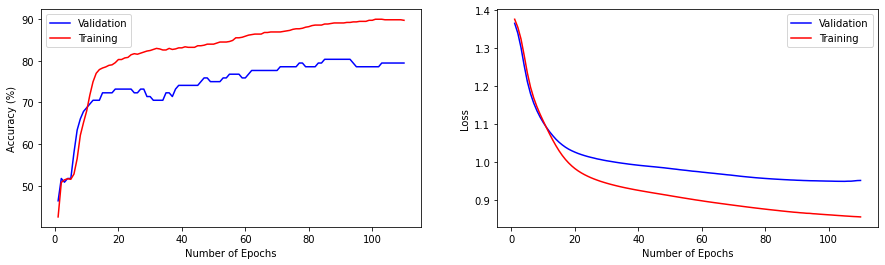

In [ ]:
# TODO: Implement your plots here, you can use matplotlib library to do so.
fig,ax = plt.subplots(1,2,figsize=(15,4))
ax[0].plot([x for x in range(1,max_epoch+1)],validation_accuracy_per_epoch,color="blue",label="Validation")
ax[0].plot([x for x in range(1,max_epoch+1)],training_accuracy_per_epoch,color="red",label="Training")
ax[0].set_xlabel("Number of Epochs")
ax[0].set_ylabel("Accuracy (%)")
ax[0].legend(loc="best")
ax[1].plot([x for x in range(1,max_epoch+1)],validation_loss_per_epoch,color="blue",label="Validation")
ax[1].plot([x for x in range(1,max_epoch+1)],training_loss_per_epoch,color="red",label="Training")
ax[1].set_xlabel("Number of Epochs")
ax[1].set_ylabel("Loss")
ax[1].legend(loc="best")
plt.show()

### Test [5 points]
As the final step of your analysis, you will test your model using some metrics. For the best model you obtained during training, evaluate your model on the test set. Then, report the confusion matrix. Finally, report accuracy, precision, recall, and $F_1$ score using your model. Report all these metrics using the macro form (macro precision, macro recall, etc.). You can implement these metrics in the cell below. 

Accuracy: 0.8672566371681416
Macro Recall: 0.863999766573296
Macro Precision: 0.8561075962096529
Macro F1 Score: 0.8589791213938747


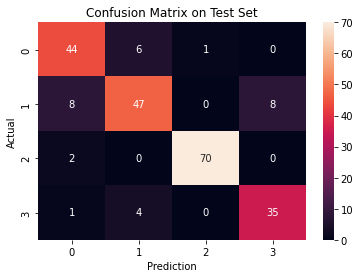

In [ ]:
# TODO: Implement your evaluation script here, provide the confusion matrix and the requested metrics
model = torch.load("best_fcn_model.pth")
model.eval()

with torch.no_grad():
  for x_test_batch, y_test_batch in test_loader: #full batch
    x_test_batch = x_test_batch.to(device)
    y_test_batch = y_test_batch.to(device)
    y_pred = model(x_test_batch)
    l = loss_function(y_pred,y_test_batch)
    pred = y_pred.argmax(dim=1).cpu()
    truth = y_test_batch.argmax(dim=1).cpu()
    accuracy = accuracy_score(truth,pred)    
    recall_macro = recall_score(truth,pred,average="macro")   
    precision_macro = precision_score(truth,pred,average="macro")
    f1_score_macro = f1_score(truth,pred,average="macro")
    cmatrix = confusion_matrix(truth,pred)
    print(f"Accuracy: {accuracy}")
    print(f"Macro Recall: {recall_macro}")
    print(f"Macro Precision: {precision_macro}")
    print(f"Macro F1 Score: {f1_score_macro}")
    sns.heatmap(cmatrix, annot=True)
    plt.title("Confusion Matrix on Test Set")
    plt.ylabel("Actual")
    plt.xlabel("Prediction")

## Training and evaluation of CNN [22 points]
Similar to the FCN model, you will now train the CNN model that you defined before. Again you are free to try out different hyperparameters. This model also will classify weather images with the four classes provided by the dataset. As the optimizer, again, use the SGD implementation provided by PyTorch. You can implement the training loop in the following cell. 

Similar to the training procedure, you need to save the best model you obtain during training. Select an appropriate criterion (metric) to save the best model. If you wish, you can add a markdown cell to explain your reasoning.

### Training [12 points]

In [ ]:
#HINT: note that your training time should not take many days.

#TODO:
#Pick your hyper parameters
max_epoch = 150
train_batch = 64
test_batch = test_dataset.__len__() #full batch for test dataset
learning_rate = 6e-3
momentum = 0.8
weight_decay = 5e-04

#DataLoader objects for mini-batches
train_loader = DataLoader(train_dataset,batch_size=train_batch)
val_loader = DataLoader(val_dataset,batch_size=val_dataset.__len__())
test_loader = DataLoader(test_dataset,batch_size=test_batch)

model = ConvNet()
model = model.to(device)
loss_function = nn.CrossEntropyLoss()    
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

training_loss_per_epoch = []
training_accuracy_per_epoch = []
validation_accuracy_per_epoch = []
validation_loss_per_epoch = []

current_min_validation_loss = np.inf #this will be used when saving the best model

# TODO: training loop + eval
for epoch in range(max_epoch):
  model.train()
  training_correct = 0
  training_loss_per_batch = [] #Mean of this list will be taken for training loss per epoch

  #Training
  for x_train_batch, y_train_batch in train_loader:
    x_train_batch = x_train_batch.to(device)
    y_train_batch = y_train_batch.to(device)
    y_pred = model(x_train_batch)
    l = loss_function(y_pred,y_train_batch)
    l.backward()
    optimizer.step()
    optimizer.zero_grad()
    pred = y_pred.argmax(dim=1)
    truth = y_train_batch.argmax(dim=1)
    training_correct += torch.eq(truth, pred).sum().item()
    training_loss_per_batch.append(l.item())
  
  #Validation
  with torch.no_grad():
    for x_val, y_val in val_loader:
      x_val = x_val.to(device)
      y_val = y_val.to(device)
      optimizer.zero_grad()
      y_pred = model(x_val)
      l = loss_function(y_pred,y_val)
      pred = y_pred.argmax(dim=1)
      truth = y_val.argmax(dim=1)
      val_correct = torch.eq(truth, pred).sum().item()
      val_accuracy = 100*val_correct/pred.size()[0]
      validation_accuracy_per_epoch.append(val_accuracy)
      training_accuracy = 100 * training_correct / train_loader.dataset.__len__()
      training_accuracy_per_epoch.append(training_accuracy)
      validation_loss_per_epoch.append(l.item())
      training_loss = np.mean(training_loss_per_batch)
      training_loss_per_epoch.append(training_loss)
      #Save the best model per epoch
      #validation loss is seletected as a metric for this process
      avg_validation_error = np.mean(validation_loss_per_epoch)
      if avg_validation_error < current_min_validation_loss:
        torch.save(model,"best_cnn_model.pth")
        current_min_validation_loss = avg_validation_error
      print(f"Epoch:{epoch+1}------> Validation error:{l.item()} Validation accuracy:{val_accuracy}% Training error:{training_loss} Training accuracy:{training_accuracy}%")

Epoch:1------> Validation error:1.3820229768753052 Validation accuracy:29.464285714285715% Training error:1.3844428154138417 Training accuracy:29.35196950444727%
Epoch:2------> Validation error:1.3774237632751465 Validation accuracy:29.464285714285715% Training error:1.37949761060568 Training accuracy:32.020330368487926%
Epoch:3------> Validation error:1.3722859621047974 Validation accuracy:29.464285714285715% Training error:1.3740112139628484 Training accuracy:32.020330368487926%
Epoch:4------> Validation error:1.3663785457611084 Validation accuracy:29.464285714285715% Training error:1.3677332492975087 Training accuracy:32.020330368487926%
Epoch:5------> Validation error:1.3596237897872925 Validation accuracy:29.464285714285715% Training error:1.3605241133616521 Training accuracy:32.020330368487926%
Epoch:6------> Validation error:1.3521764278411865 Validation accuracy:29.464285714285715% Training error:1.3525221622907198 Training accuracy:32.020330368487926%
Epoch:7------> Validation

### Learning Process Analysis [3 points]
Repeating the same procedure you applied for the FCN model; you will provide two plots about how your training proceeds over epochs. Again, provide two plots: one summarizes the loss values, and the other summarizes the accuracy values. Note that each plot needs to include two curves, one for the validation set and the other for the training set.

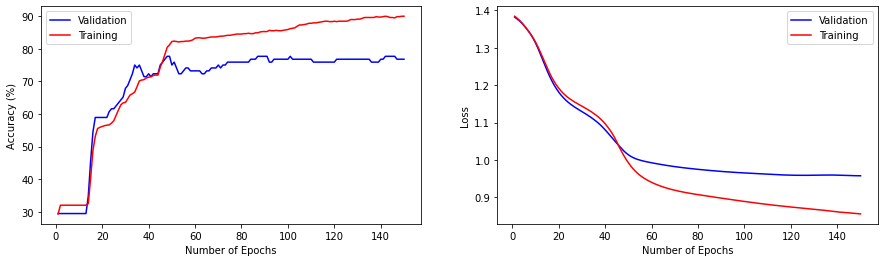

In [ ]:
# TODO: Implement your plots here, you can use matplotlib library to do so.
fig,ax = plt.subplots(1,2,figsize=(15,4))
ax[0].plot([x for x in range(1,max_epoch+1)],validation_accuracy_per_epoch,color="blue",label="Validation")
ax[0].plot([x for x in range(1,max_epoch+1)],training_accuracy_per_epoch,color="red",label="Training")
ax[0].set_xlabel("Number of Epochs")
ax[0].set_ylabel("Accuracy (%)")
ax[0].legend(loc="best")
ax[1].plot([x for x in range(1,max_epoch+1)],validation_loss_per_epoch,color="blue",label="Validation")
ax[1].plot([x for x in range(1,max_epoch+1)],training_loss_per_epoch,color="red",label="Training")
ax[1].set_xlabel("Number of Epochs")
ax[1].set_ylabel("Loss")
ax[1].legend(loc="best")
plt.show()

### Test [4 points]
Concluding your analysis, report the confusion matrix for the best model you obtained during your CNN model training. Then using this confusion matrix, report accuracy, recall, precision, and $F_1$ score for your best model. Use macro averaging in all of your metrics.

Accuracy: 0.8893805309734514
Macro Recall: 0.8907913165266106
Macro Precision: 0.8791751314932885
Macro F1 Score: 0.8799622616900671


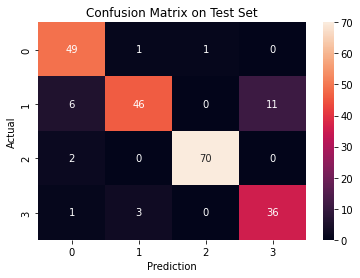

In [ ]:
# TODO: Implement your evaluation script here, provide the confusion matrix and the requested metrics
model = torch.load("best_cnn_model.pth")
model.eval()

with torch.no_grad():
  for x_test_batch, y_test_batch in test_loader: #full batch
    x_test_batch = x_test_batch.to(device)
    y_test_batch = y_test_batch.to(device)
    y_pred = model(x_test_batch)
    l = loss_function(y_pred,y_test_batch)
    pred = y_pred.argmax(dim=1).cpu()
    truth = y_test_batch.argmax(dim=1).cpu()
    accuracy = accuracy_score(truth,pred)    
    recall_macro = recall_score(truth,pred,average="macro")   
    precision_macro = precision_score(truth,pred,average="macro")
    f1_score_macro = f1_score(truth,pred,average="macro")
    cmatrix = confusion_matrix(truth,pred)
    print(f"Accuracy: {accuracy}")
    print(f"Macro Recall: {recall_macro}")
    print(f"Macro Precision: {precision_macro}")
    print(f"Macro F1 Score: {f1_score_macro}")
    sns.heatmap(cmatrix, annot=True)
    plt.title("Confusion Matrix on Test Set")
    plt.ylabel("Actual")
    plt.xlabel("Prediction")

### Discussion [3 points]
Now, try to compare the two models that you trained. How different are these two models regarding the number of parameters used?

Explain your findings by connecting them with your experimental results. You can include your comments on a separate Markdown cell or below the question statement.

## Transfer Learning [22 points]

As the last part of this assignment, you will practice transfer learning. In this methodology, we aim to use models trained on large-scale datasets for our task. As we do not have access to large datasets and computational resources all the time, we sometimes try to use already trained models (on other datasets) as a good starting point for our model, and then fine-tune the weights considering our task.  

Torchvision library provides numerous models pretrained for specific tasks. [Here](https://pytorch.org/vision/stable/models.html), you can find a list of pretrained models. For this part, you will include [ResNet](https://arxiv.org/abs/1512.03385)-18 model, pretrained with ImageNet dataset. ImageNet is a large dataset where training from scratch would take a long time. You will fine-tune this pretrained module for your task. 
<br>
**Hint:** You can add a Linear layer to adapt the model to the number of classes needed for your task. You can access the number of inputs to the ResNet-18 model as $\texttt{model.fc.in_features}$ and then modify the fully connected layer of the model $\texttt{model.fc}$.
<br>

Using the ResNet-18 backbone, implement this model's training loop (by adapting it to your task). You can implement the training procedure in the cell provided below. Again save your model based on a criterion indicating the best model. Explain the reasoning for your criteria. Use the SGD optimizer provided by PyTorch to optimize your model.

Just like the previous parts, you can also tune your hyperparameters to optimize your model's performance. 

###Training [12 points]

In [ ]:
#HINT: note that your training time should not take many days.

#TODO:
#Pick your hyper parameters
max_epoch = 10
train_batch = 64
test_batch = test_dataset.__len__()
learning_rate = 9e-2
weight_decay = 5e-04

#DataLoader objects for mini-batches
train_loader = DataLoader(train_dataset,batch_size=train_batch)
val_loader = DataLoader(val_dataset,batch_size=val_dataset.__len__())
test_loader = DataLoader(test_dataset,batch_size=test_batch)

#Get resnet18 model and update classification layer according to this project's layer count
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features,4)
model = model.to(device)

#Determine loss function and the optimizer
loss_function = nn.CrossEntropyLoss()    
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

training_loss_per_epoch = []
training_accuracy_per_epoch = []
validation_accuracy_per_epoch = []
validation_loss_per_epoch = []

current_min_validation_loss = np.inf #this will be used when saving the best model

# TODO: Implement training loop + eval using ResNet-18 model
for epoch in range(max_epoch):
  model.train()
  training_correct = 0
  training_loss_per_batch = [] #Mean of this list will be taken for training loss per epoch

  #Training
  for x_train_batch, y_train_batch in train_loader:
    x_train_batch = x_train_batch.to(device)
    y_train_batch = y_train_batch.to(device)
    y_pred = model(x_train_batch)
    l = loss_function(y_pred,y_train_batch)
    l.backward()
    optimizer.step()
    optimizer.zero_grad()
    pred = y_pred.argmax(dim=1)
    truth = y_train_batch.argmax(dim=1)
    training_correct += torch.eq(truth, pred).sum().item()
    training_loss_per_batch.append(l.item())
  
  #Validation
  with torch.no_grad():
    for x_val, y_val in val_loader:
      x_val = x_val.to(device)
      y_val = y_val.to(device)
      optimizer.zero_grad()
      y_pred = model(x_val)
      l = loss_function(y_pred,y_val)
      pred = y_pred.argmax(dim=1)
      truth = y_val.argmax(dim=1)
      val_correct = torch.eq(truth, pred).sum().item()
      val_accuracy = 100*val_correct/pred.size()[0]
      validation_accuracy_per_epoch.append(val_accuracy)
      training_accuracy = 100 * training_correct / train_loader.dataset.__len__()
      training_accuracy_per_epoch.append(training_accuracy)
      validation_loss_per_epoch.append(l.item())
      training_loss = np.mean(training_loss_per_batch)
      training_loss_per_epoch.append(training_loss)
      #Save the best model per epoch
      #validation loss is seletected as a metric for this process
      avg_validation_error = np.mean(validation_loss_per_epoch)
      if avg_validation_error < current_min_validation_loss:
        torch.save(model,"best_resnet18_model.pth")
        current_min_validation_loss = avg_validation_error
      print(f"Epoch:{epoch+1}------> Validation error:{l.item()} Validation accuracy:{val_accuracy}% Training error:{training_loss} Training accuracy:{training_accuracy}%")



/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch:1------> Validation error:0.2490309774875641 Validation accuracy:91.07142857142857% Training error:3.774613676735988 Training accuracy:57.941550190597205%
Epoch:2------> Validation error:0.08792508393526077 Validation accuracy:96.42857142857143% Training error:0.28278801504236 Training accuracy:91.35959339263025%
Epoch:3------> Validation error:0.045596323907375336 Validation accuracy:99.10714285714286% Training error:0.10154876141594006 Training accuracy:96.44218551461245%
Epoch:4------> Validation error:0.03232952952384949 Validation accuracy:99.10714285714286% Training error:0.025111910045290224 Training accuracy:99.11054637865311%
Epoch:5------> Validation error:0.030184345319867134 Validation accuracy:99.10714285714286% Training error:0.00802628277765157 Training accuracy:99.87293519695045%
Epoch:6------> Validation error:0.027967607602477074 Validation accuracy:99.10714285714286% Training error:0.00406804325309797 Training accuracy:99.87293519695045%
Epoch:7------> Validati

###Learning Process Analysis [3 points]
After training your model, provide two plots summarizing the learning procedure. Like previous parts, you will provide plots for loss value and accuracy progression over epochs. Remember that for each plot, you need to include two curves (one for the training set and one for the validation set).

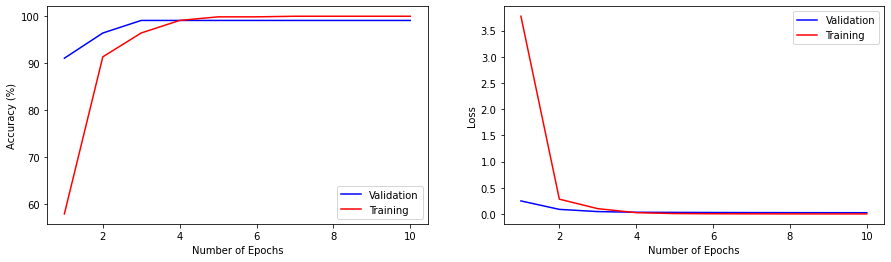

In [ ]:
# TODO: Implement your plots here, you can use matplotlib library to do so.
fig,ax = plt.subplots(1,2,figsize=(15,4))
ax[0].plot([x for x in range(1,max_epoch+1)],validation_accuracy_per_epoch,color="blue",label="Validation")
ax[0].plot([x for x in range(1,max_epoch+1)],training_accuracy_per_epoch,color="red",label="Training")
ax[0].set_xlabel("Number of Epochs")
ax[0].set_ylabel("Accuracy (%)")
ax[0].legend(loc="best")
ax[1].plot([x for x in range(1,max_epoch+1)],validation_loss_per_epoch,color="blue",label="Validation")
ax[1].plot([x for x in range(1,max_epoch+1)],training_loss_per_epoch,color="red",label="Training")
ax[1].set_xlabel("Number of Epochs")
ax[1].set_ylabel("Loss")
ax[1].legend(loc="best")
plt.show()

### Test [4 points]
Following your analysis, report the confusion matrix for the best model you obtained (with the criteria you defined). Then, report the accuracy, precision, recall and $F_1$ score for the best model. In all of the metrics, use macro averaging.

Accuracy: 0.9778761061946902
Macro Recall: 0.9797210550887021
Macro Precision: 0.9756531349724261
Macro F1 Score: 0.977485427754245


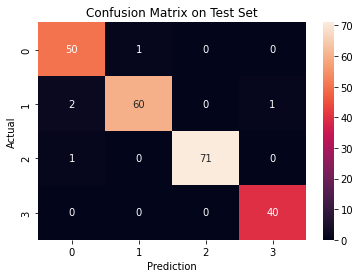

In [ ]:
# TODO: Implement your evaluation script here, provide the confusion matrix and the requested metrics
model = torch.load("best_resnet18_model.pth")
model.eval()

with torch.no_grad():
  for x_test_batch, y_test_batch in test_loader: #full batch
    x_test_batch = x_test_batch.to(device)
    y_test_batch = y_test_batch.to(device)
    y_pred = model(x_test_batch)
    l = loss_function(y_pred,y_test_batch)
    pred = y_pred.argmax(dim=1).cpu()
    truth = y_test_batch.argmax(dim=1).cpu()
    accuracy = accuracy_score(truth,pred)    
    recall_macro = recall_score(truth,pred,average="macro")   
    precision_macro = precision_score(truth,pred,average="macro")
    f1_score_macro = f1_score(truth,pred,average="macro")
    cmatrix = confusion_matrix(truth,pred)
    print(f"Accuracy: {accuracy}")
    print(f"Macro Recall: {recall_macro}")
    print(f"Macro Precision: {precision_macro}")
    print(f"Macro F1 Score: {f1_score_macro}")
    sns.heatmap(cmatrix, annot=True)
    plt.title("Confusion Matrix on Test Set")
    plt.ylabel("Actual")
    plt.xlabel("Prediction")

### Discussion [3 points]
Now discuss the effectiveness of Transfer Learning. How does it improve performance?  

The pretrained model outperformed other 2 models. It reached to the validation accuracy of %99.10 in 3 epochs. This is possible because the weights of the pretrained model has already been optimized. The training process of this project tuned the weights of the pretrained model so that it can be used for our dataset too.   

# References
[1] Ajayi, Gbeminiyi (2018), “Multi-class Weather Dataset for Image Classification”, Mendeley Data, V1, doi: 10.17632/4drtyfjtfy.1